In [32]:
%pip install scikit-learn


     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   --- ------------------------------------ 0.9/11.0 MB 28.4 MB/s eta 0:00:01
   -------- ------------------------------- 2.3/11.0 MB 29.0 MB/s eta 0:00:01
   -------------- ------------------------- 4.0/11.0 MB 36.5 MB/s eta 0:00:01
   --------------------- ------------------ 6.0/11.0 MB 38.3 MB/s eta 0:00:01
   ------------------------------ --------- 8.3/11.0 MB 44.1 MB/s eta 0:00:01
   ------------------------------------ --- 10.1/11.0 MB 43.3 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 40.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/301.8 kB ? eta -:--:--
   --------------------------------------- 301.8/301.8 kB 18.2 MB/s eta 0:00:00
   --

In [30]:
%pip install torch torchvision
%pip install matplotlib
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
LR = 0.01
BATCH_SIZE = 32
EPOCH = 10
DOWNLOAD_MNIST = True

In [18]:
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)
test_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=False,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

torch.Size([60000, 28, 28])
torch.Size([60000])


c:\Users\pikal\anaconda3\envs\ag\Lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\pikal\anaconda3\envs\ag\Lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


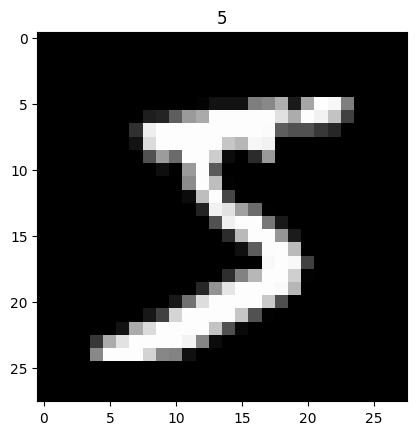

In [19]:
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [21]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x 

In [23]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [24]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss() 

In [27]:
test_x = Variable(next(iter(test_loader))[0])
test_y = next(iter(test_loader))[1]

In [33]:
from matplotlib import cm
from sklearn.manifold import TSNE
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

Epoch:  0 | train loss: 0.1138 | test accuracy: 1.00
Epoch:  0 | train loss: 0.1868 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1177 | test accuracy: 1.00
Epoch:  0 | train loss: 0.0130 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0529 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2777 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0576 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1333 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2550 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0077 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0731 | test accuracy: 1.00
Epoch:  0 | train loss: 0.1161 | test accuracy: 1.00
Epoch:  0 | train loss: 0.1150 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1410 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0039 | test accuracy: 1.00
Epoch:  0 | train loss: 0.1274 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2271 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0417 | test accuracy: 1.00
Epoch:  0 | train loss: 0.0121 | test accuracy

In [34]:
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

[7 2 1 0 4 1 4 9 8 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
